# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
display(df_reviews.head(5))

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Let's check the number of movies and reviews over years.

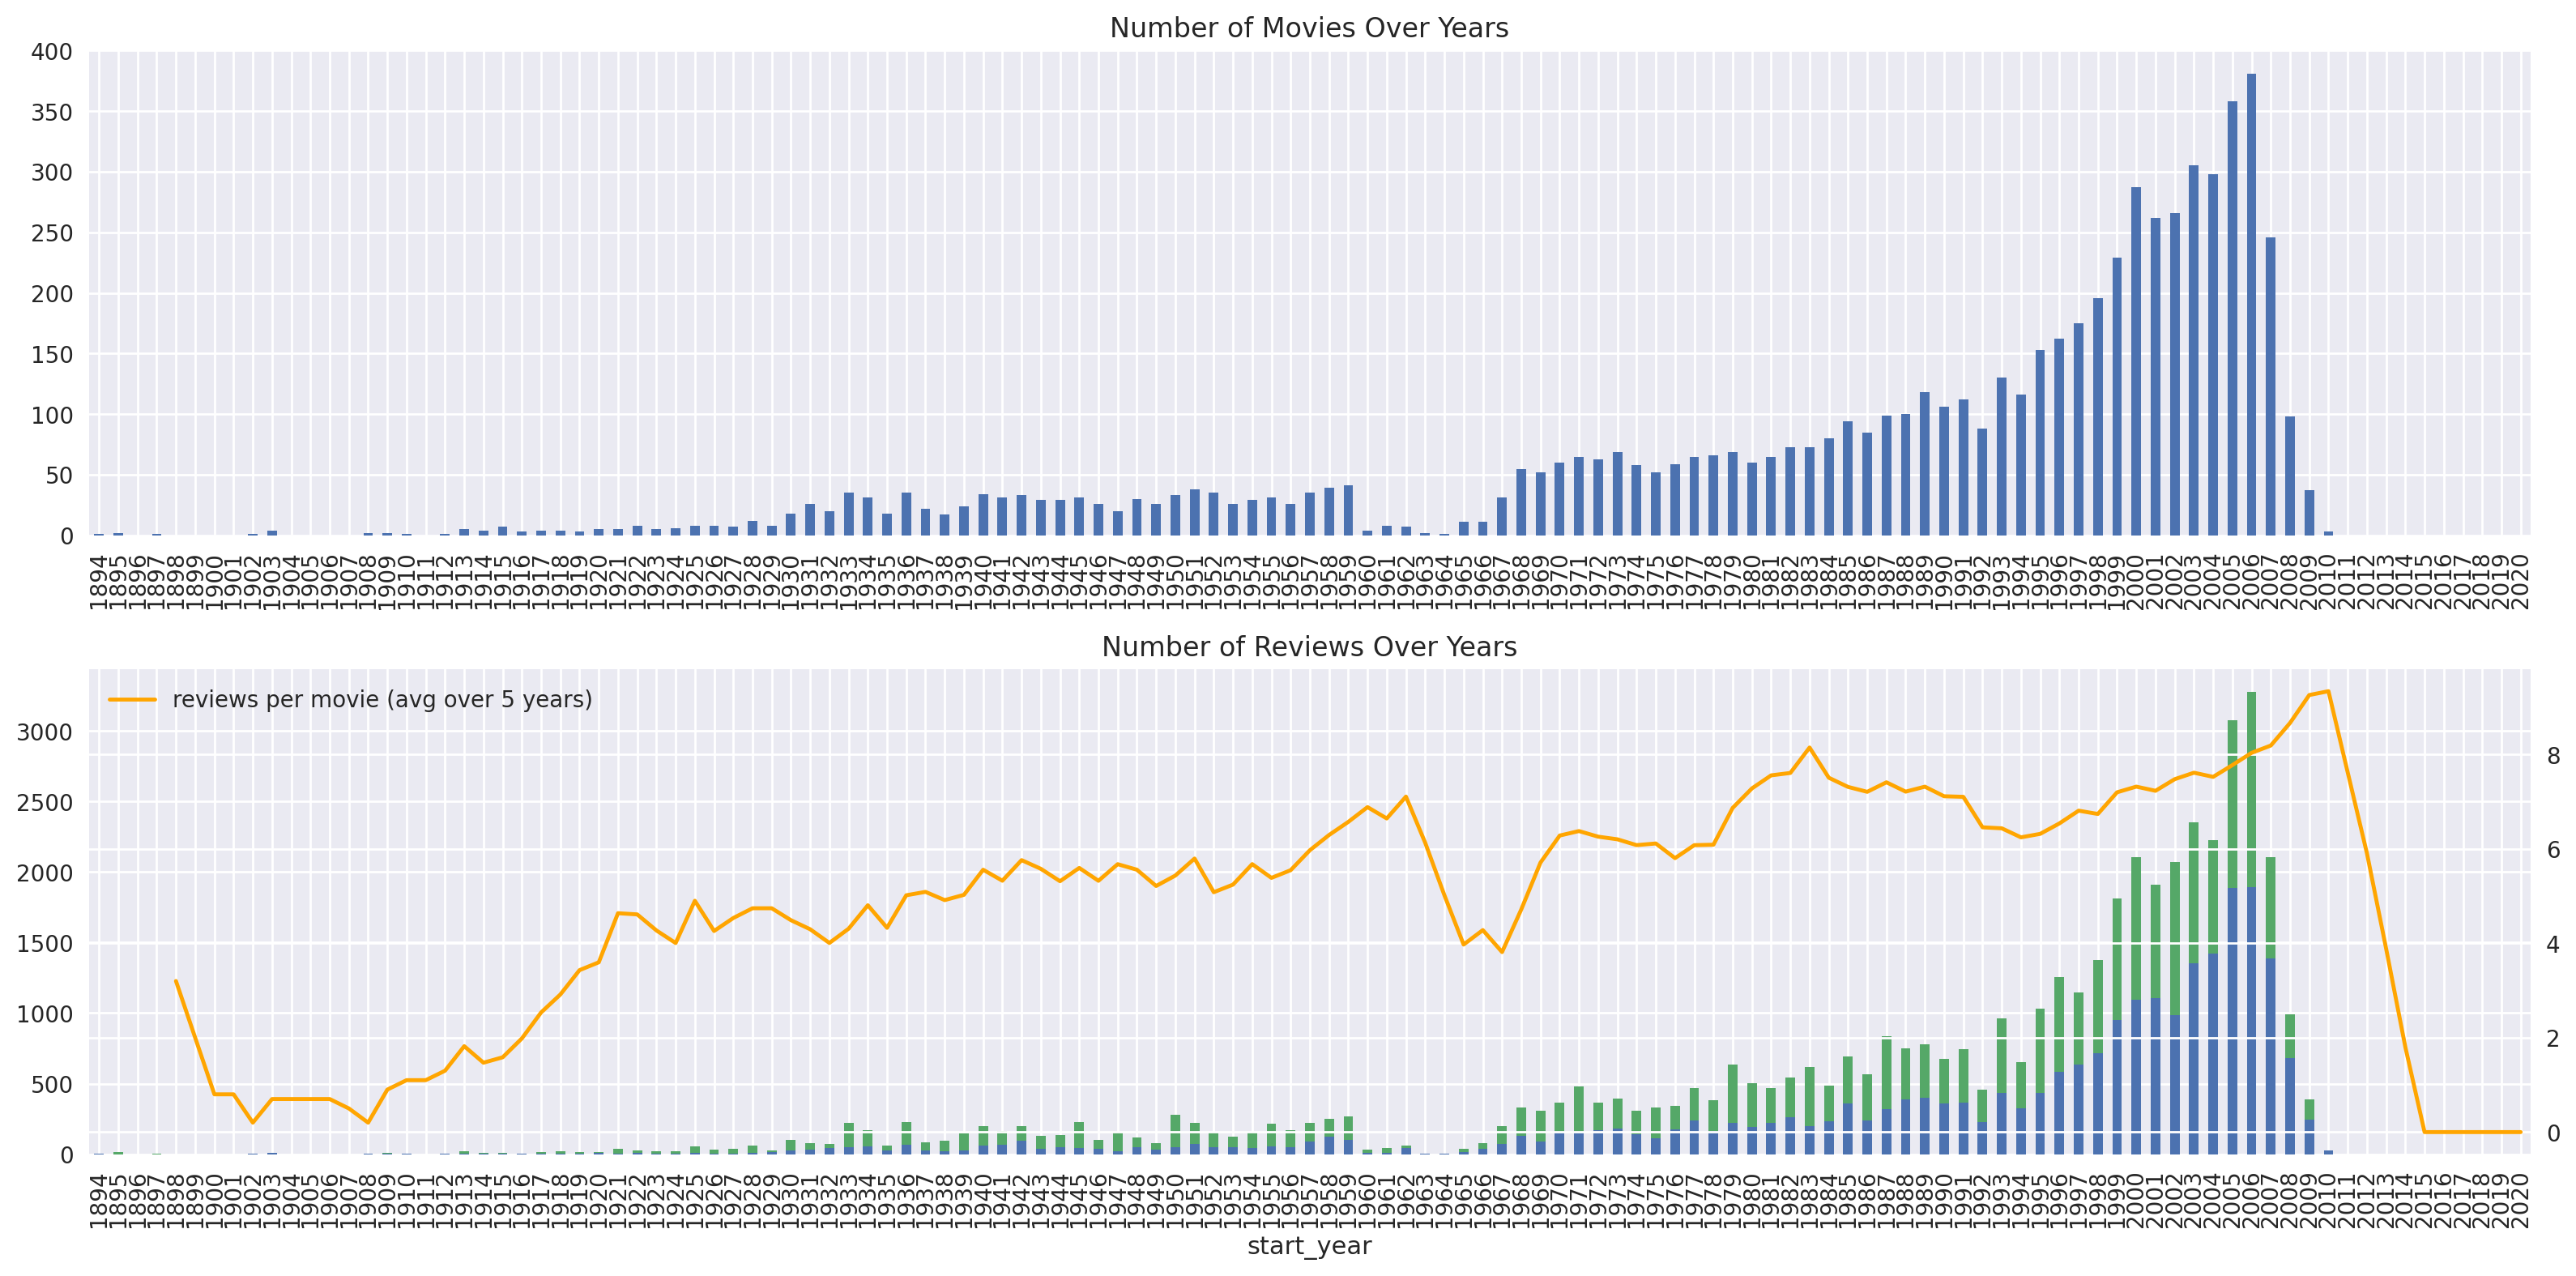

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

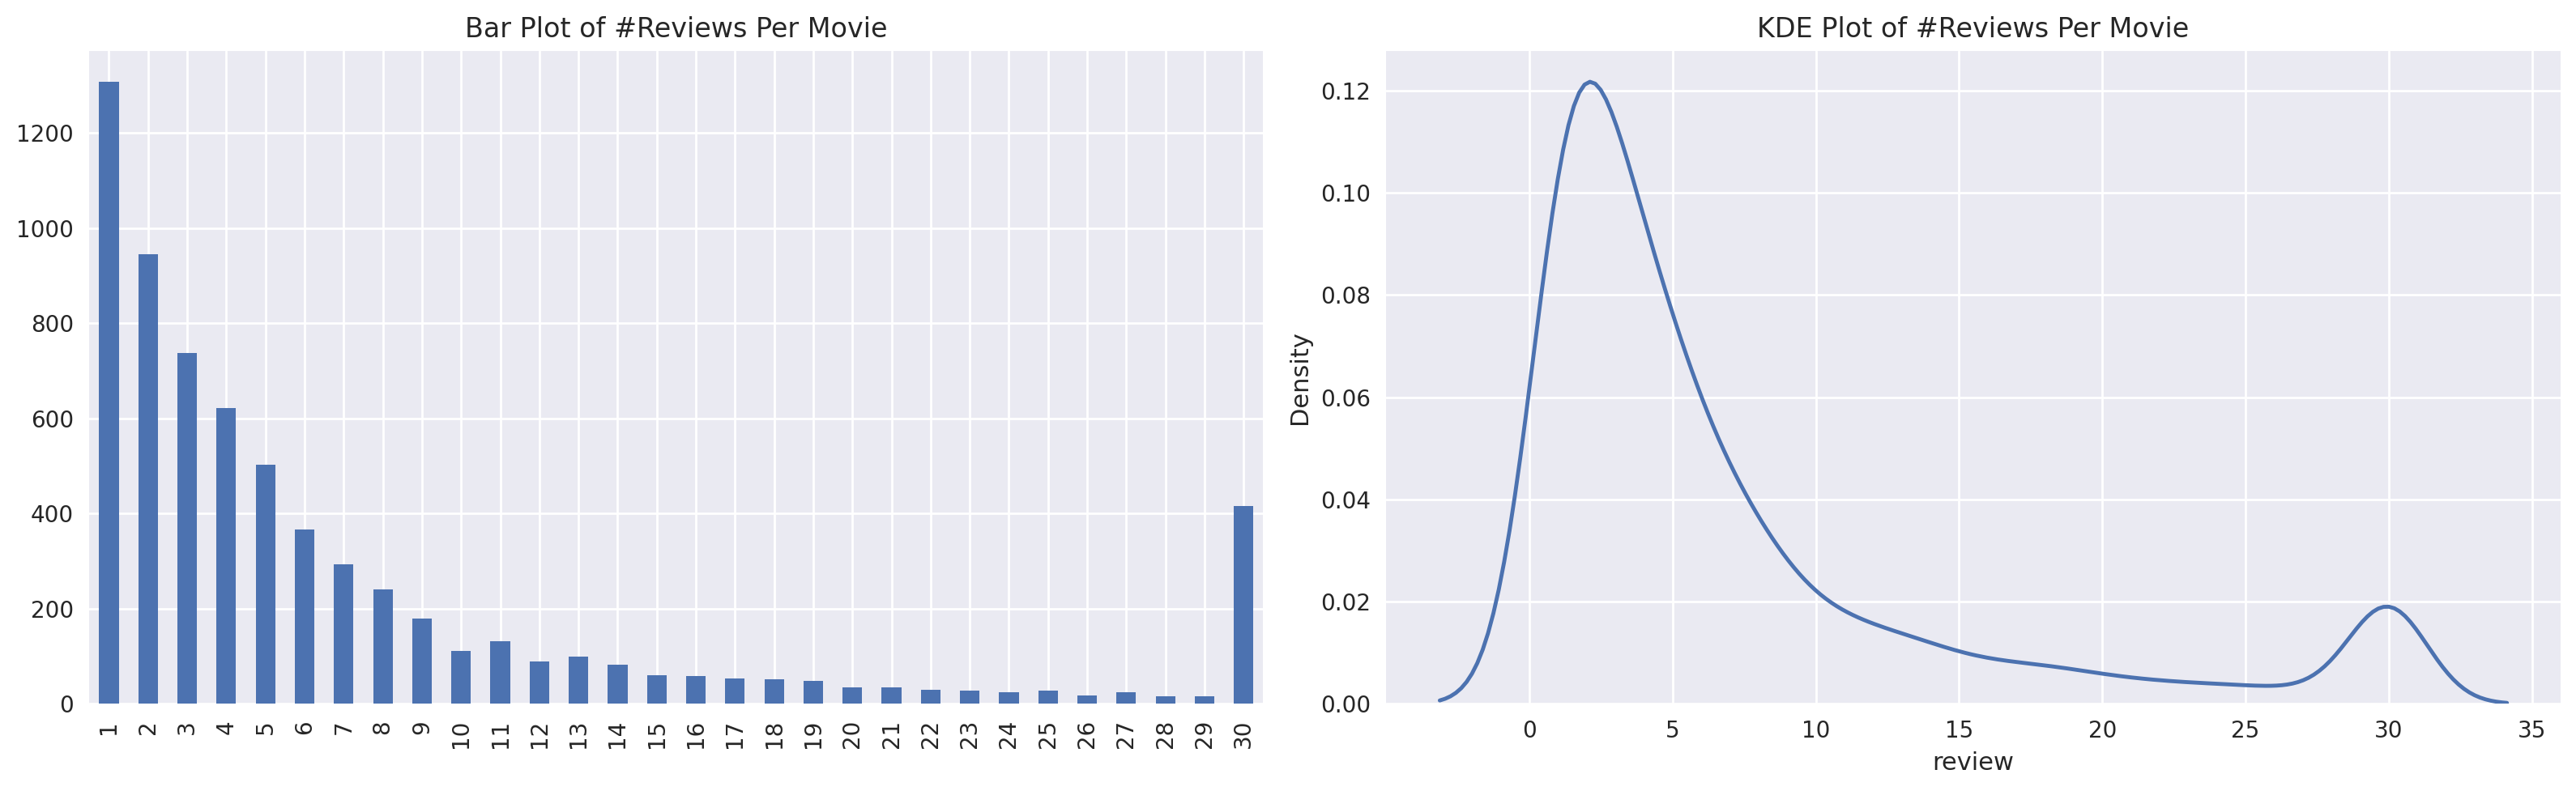

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

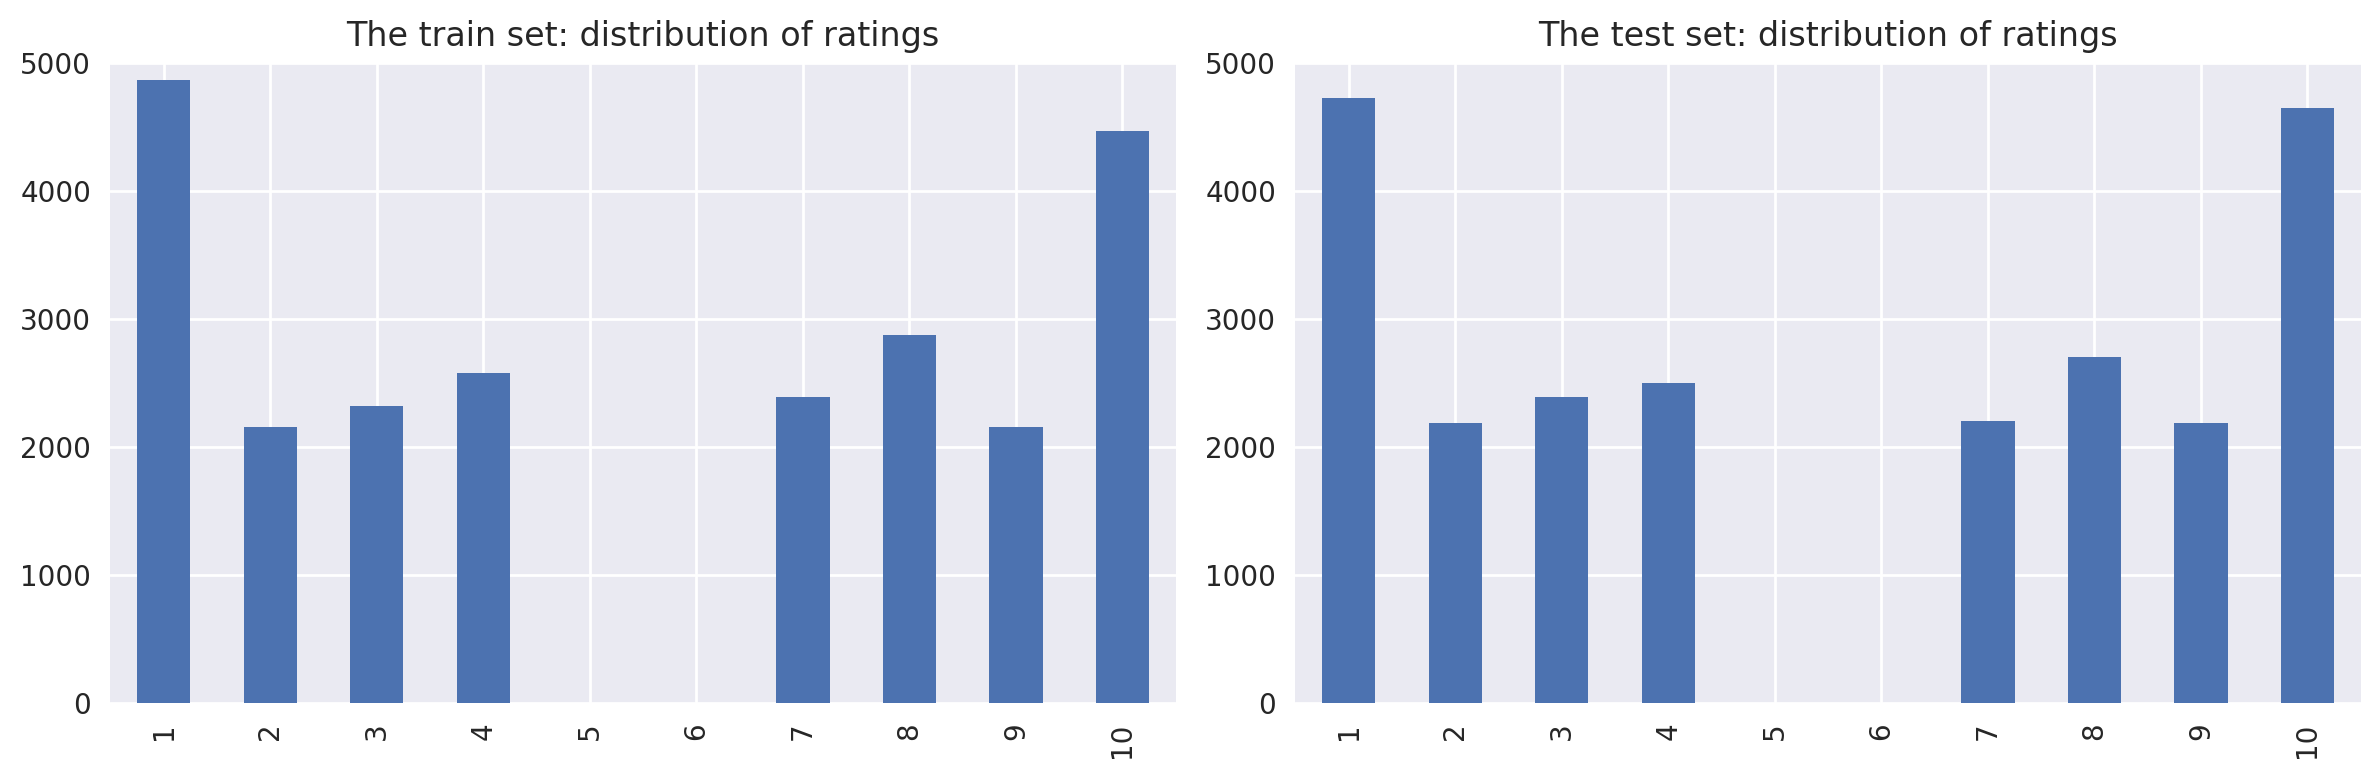

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


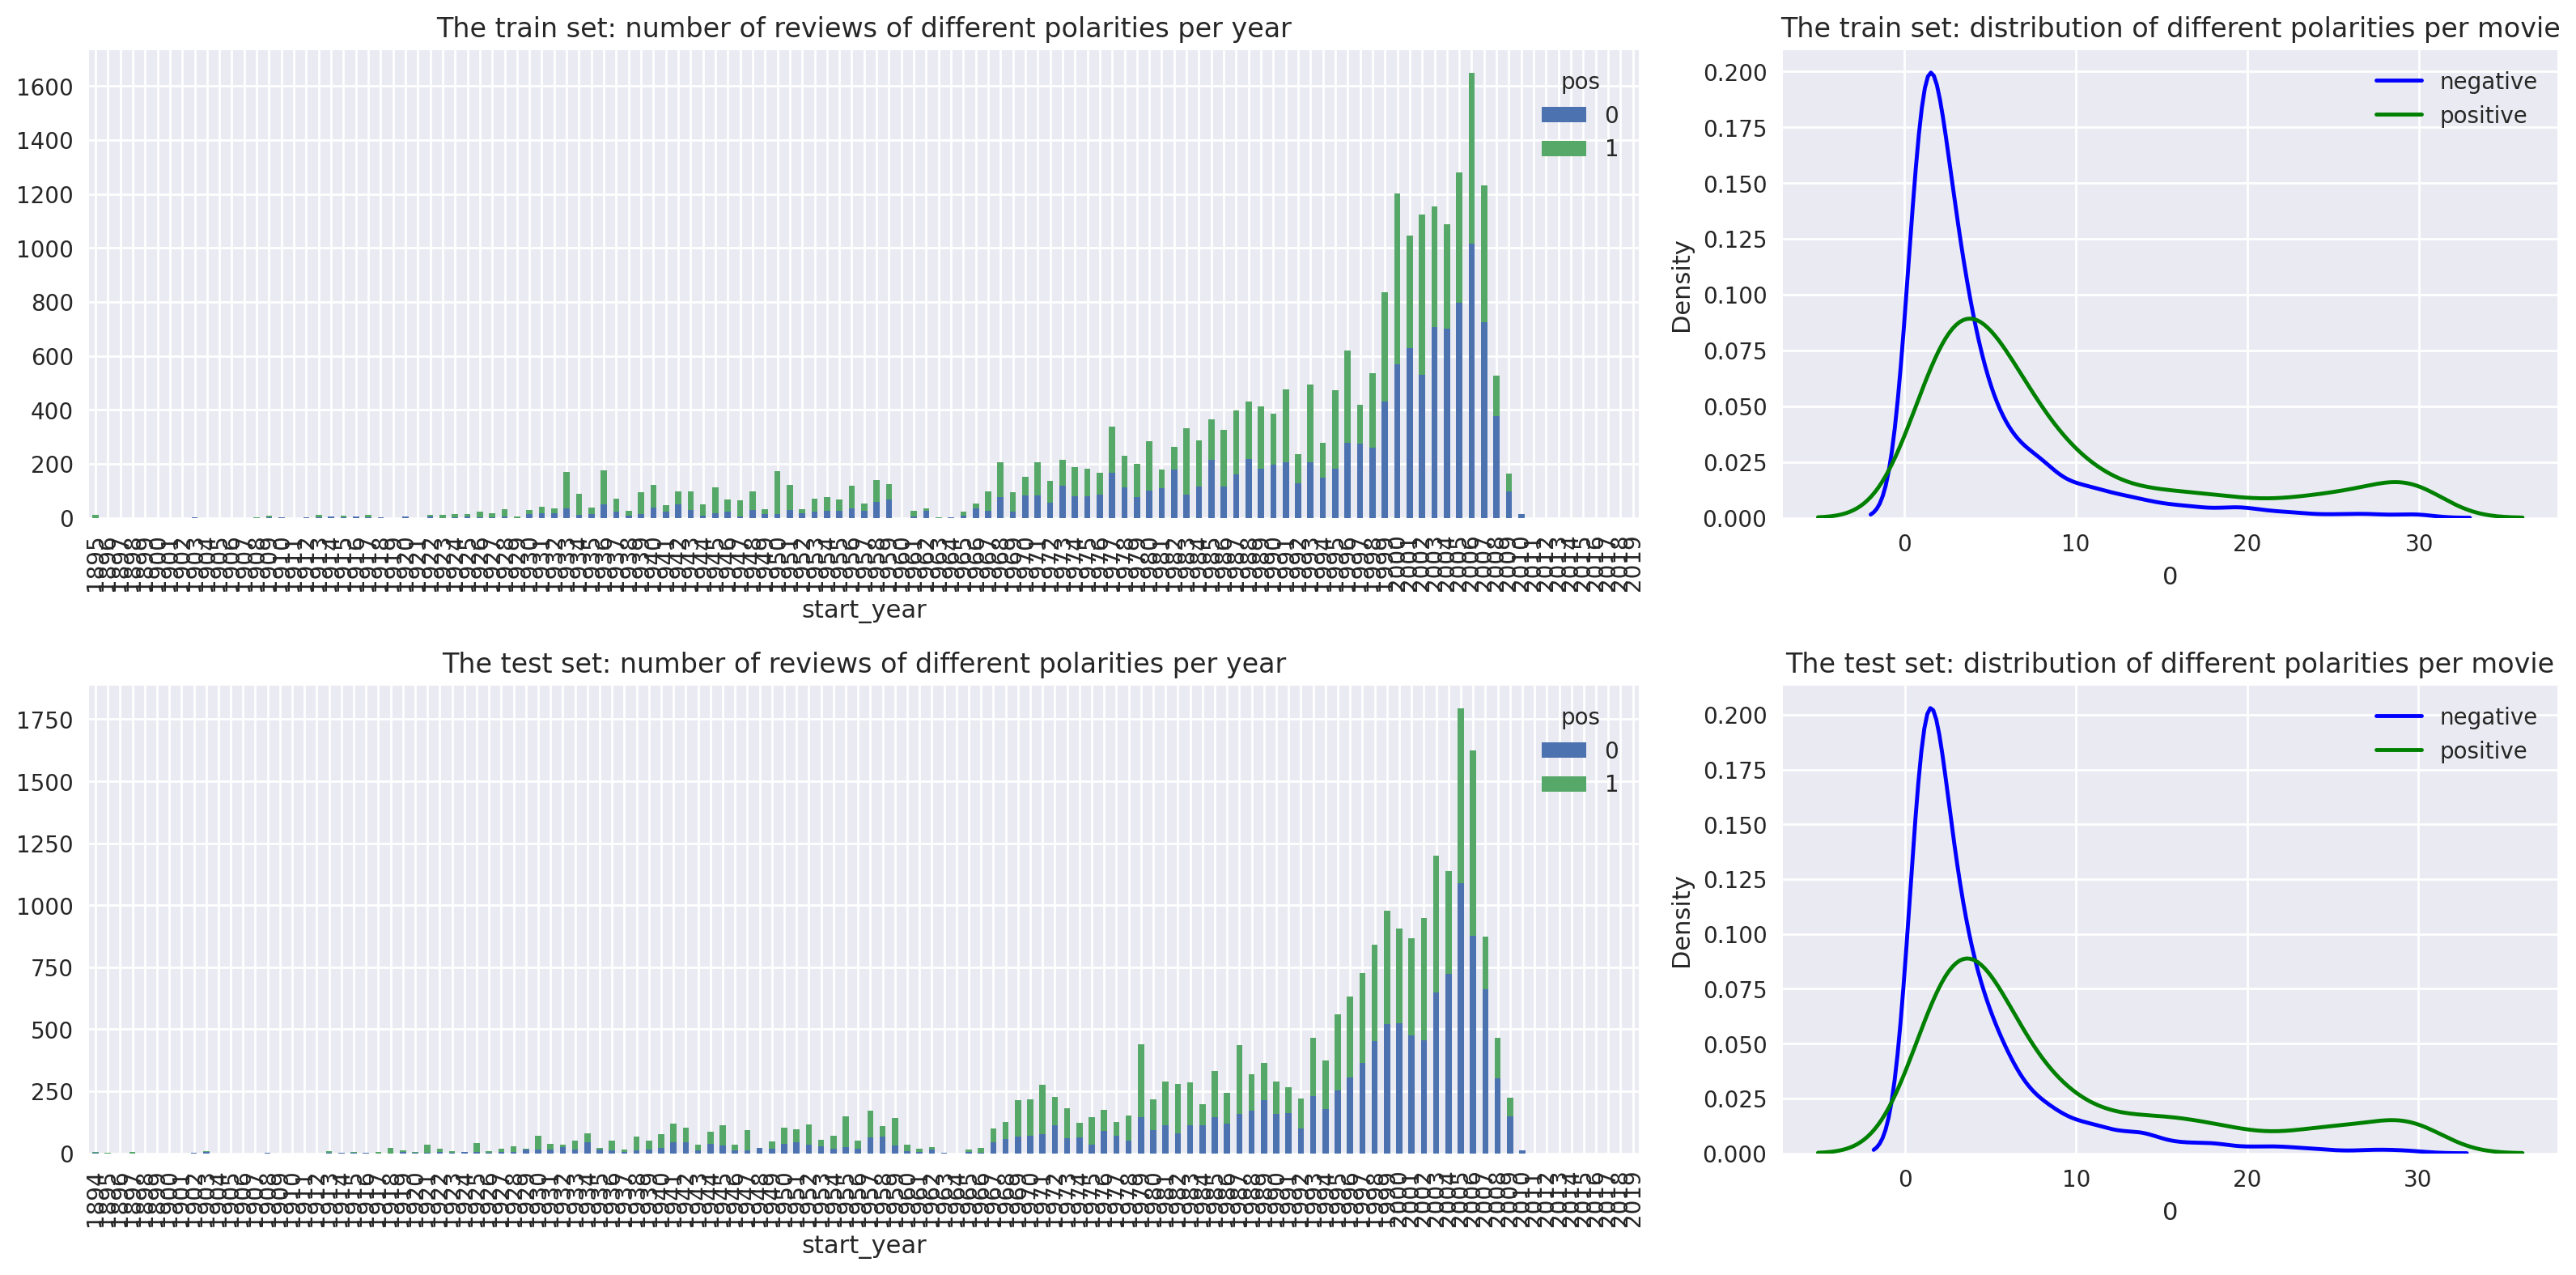

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
import re

df_reviews['review_norm'] = df_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [14]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
None


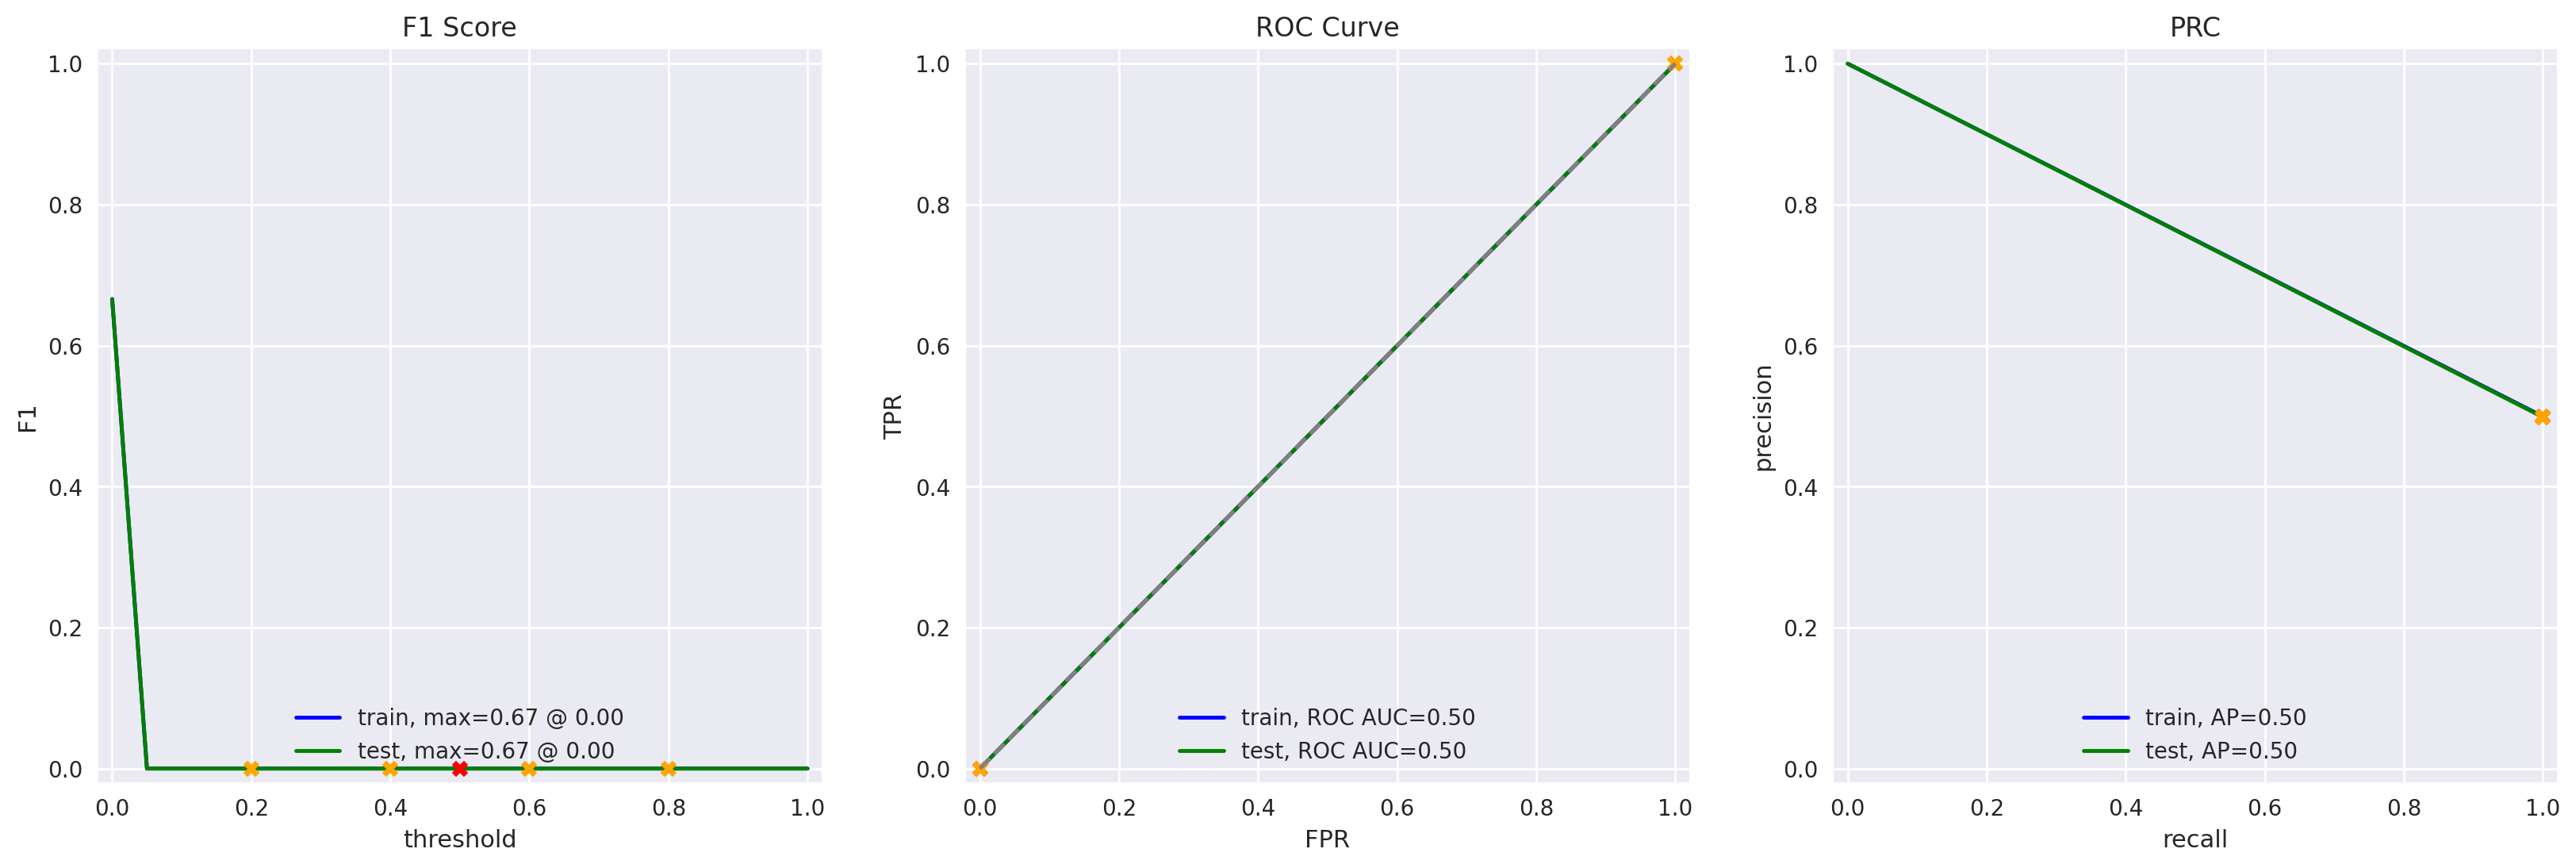

In [15]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=123)
dummy_model = dummy_clf.fit(df_reviews_train, train_target)
print(evaluate_model(dummy_model, df_reviews_train, train_target, df_reviews_test, test_target))

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


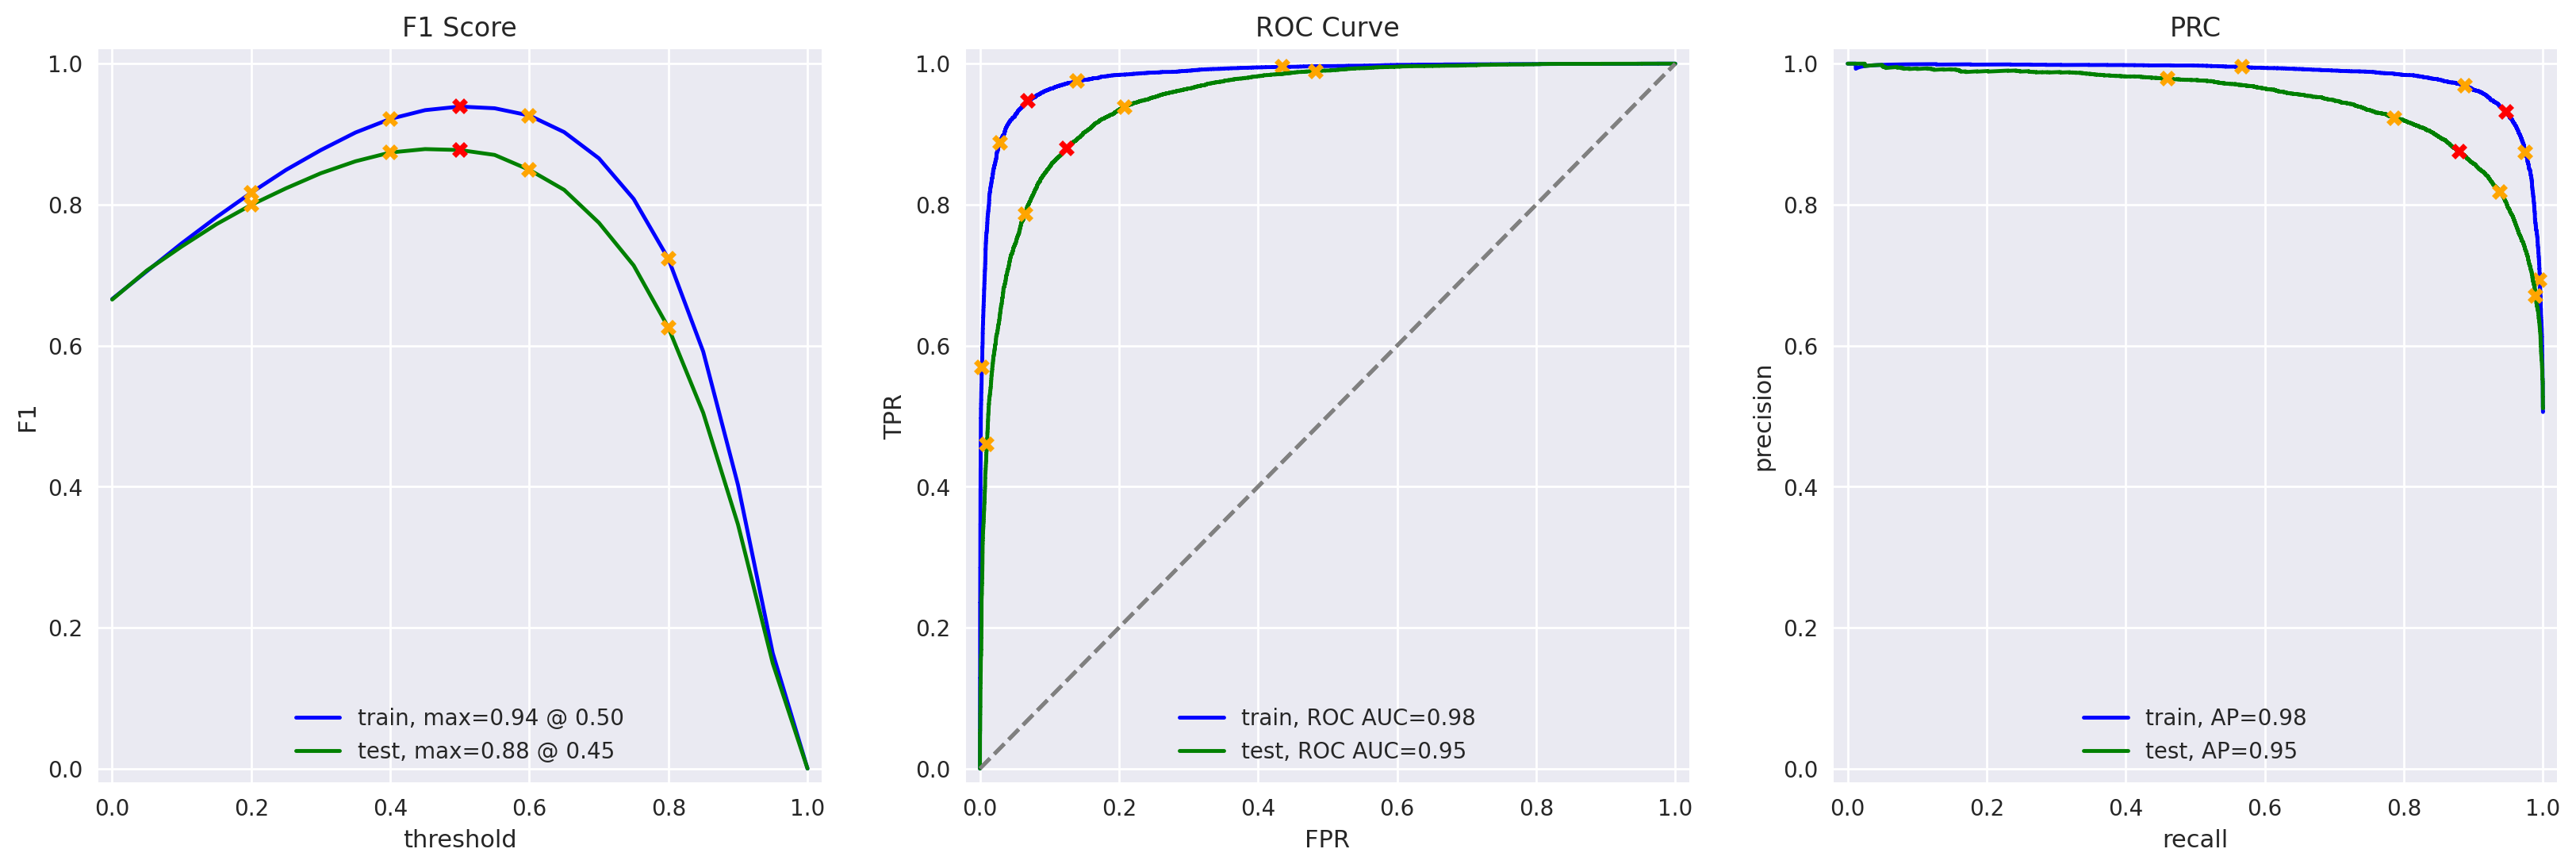

In [17]:
##TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
df_reviews_train_vec = vectorizer.fit_transform(df_reviews_train['review_norm'])
df_reviews_test_vec = vectorizer.transform(df_reviews_test['review_norm'])

#create logistic regression model
tfidf_lr_model = LogisticRegression()
tfidf_lr_model.fit(df_reviews_train_vec, train_target)

evaluate_model(tfidf_lr_model, df_reviews_train_vec, train_target, df_reviews_test_vec, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [18]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
def text_preprocessing_3(text):
    text = text.lower()
    #process text with spaCy
    doc = nlp(text)
    #lemmatize/remove stop wordss
    tokens = [
        token.lemma_ for token in doc 
        if not token.is_stop and not token.is_punct and not token.is_digit and not token.is_space
    ]
    
    return ' '.join(tokens)


In [20]:
#complete text preprocessing
df_reviews_train2 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test2 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


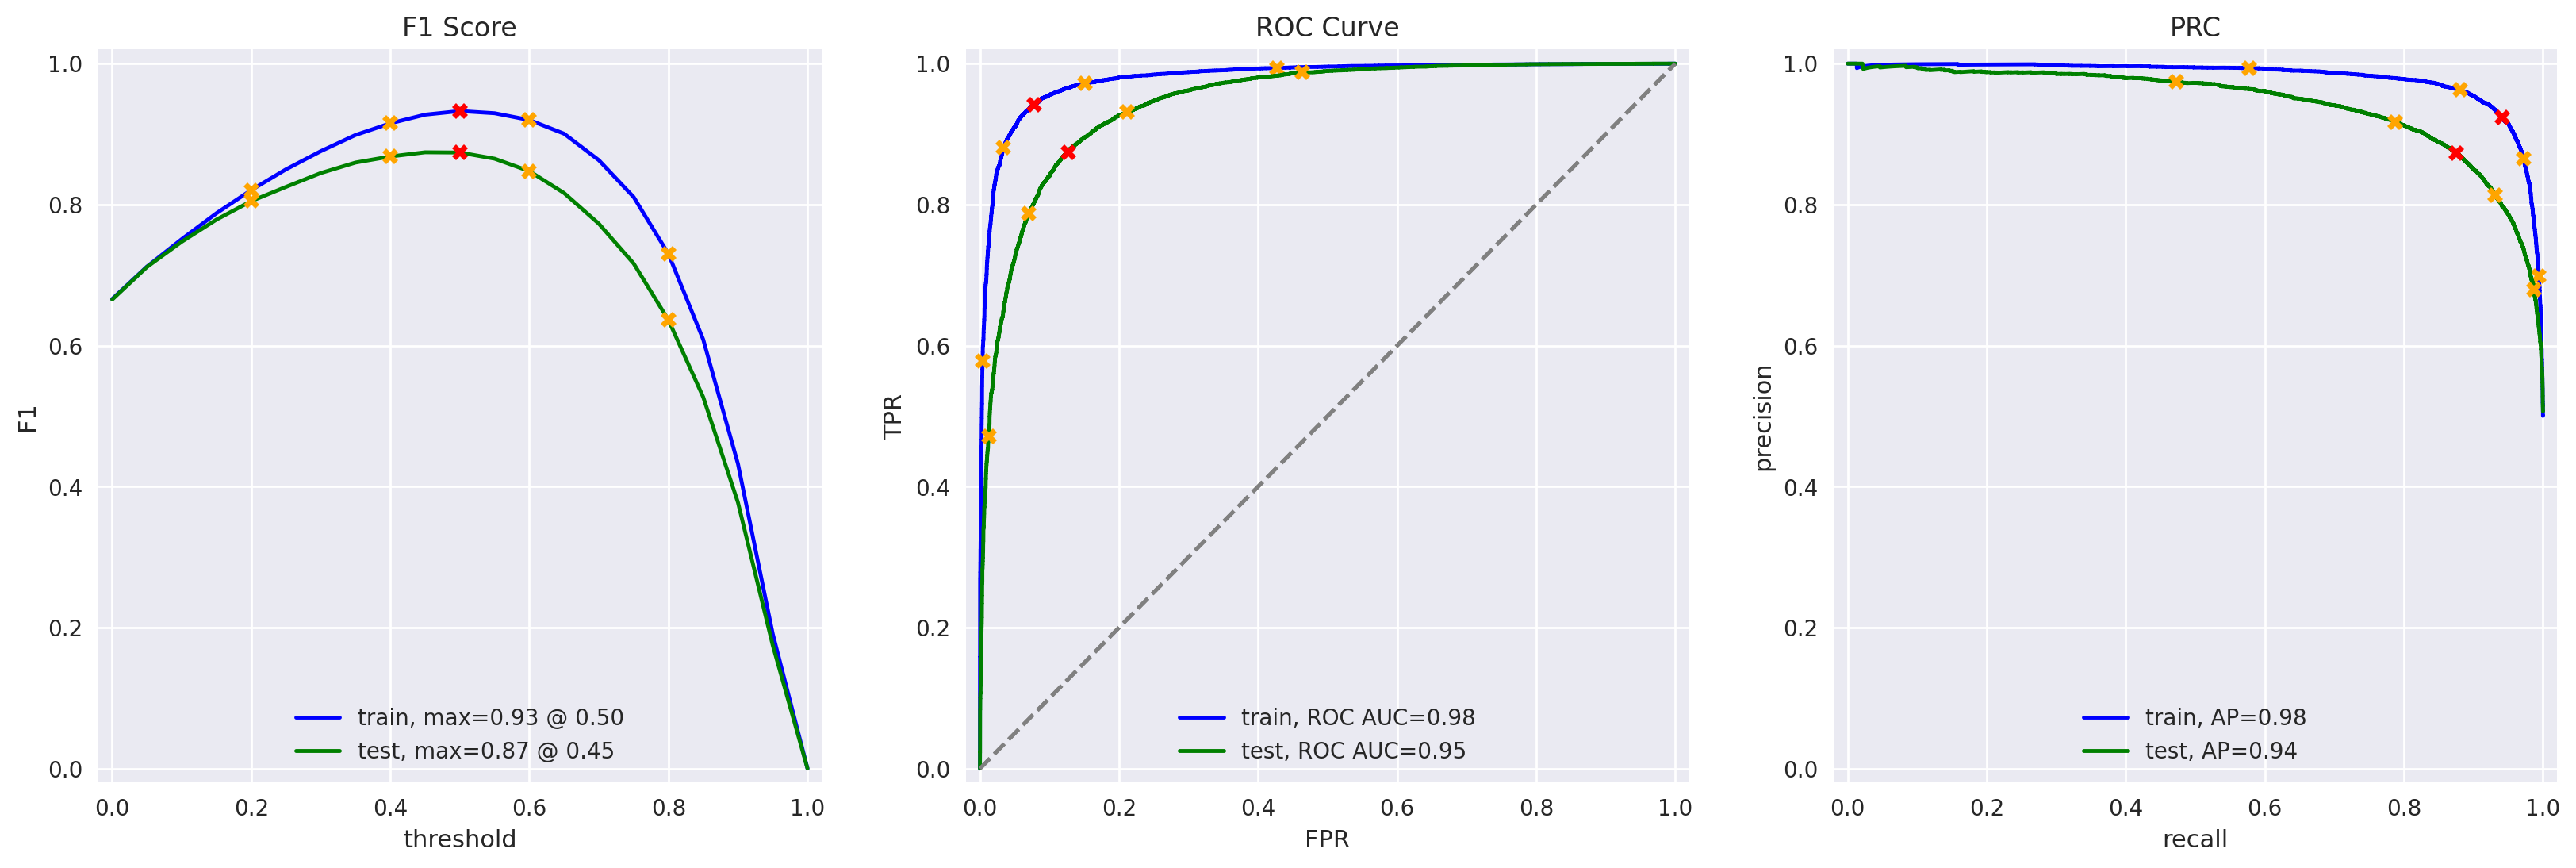

In [21]:
##TF-IDF
#create vectors and remove stop words
vectorizer3 = TfidfVectorizer()
df_reviews_train_vec = vectorizer3.fit_transform(df_reviews_train2)
df_reviews_test_vec = vectorizer3.transform(df_reviews_test2)

#create logistic regression model
tfidf_lr_model2 = LogisticRegression()
tfidf_lr_model2.fit(df_reviews_train_vec, train_target)

evaluate_model(tfidf_lr_model2, df_reviews_train_vec, train_target, df_reviews_test_vec, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [22]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [23]:
##TF-IDF
#create vectors and remove stop words
vectorizer4 = TfidfVectorizer()
df_reviews_train_vec = vectorizer4.fit_transform(df_reviews_train2)
df_reviews_test_vec = vectorizer4.transform(df_reviews_test2)

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


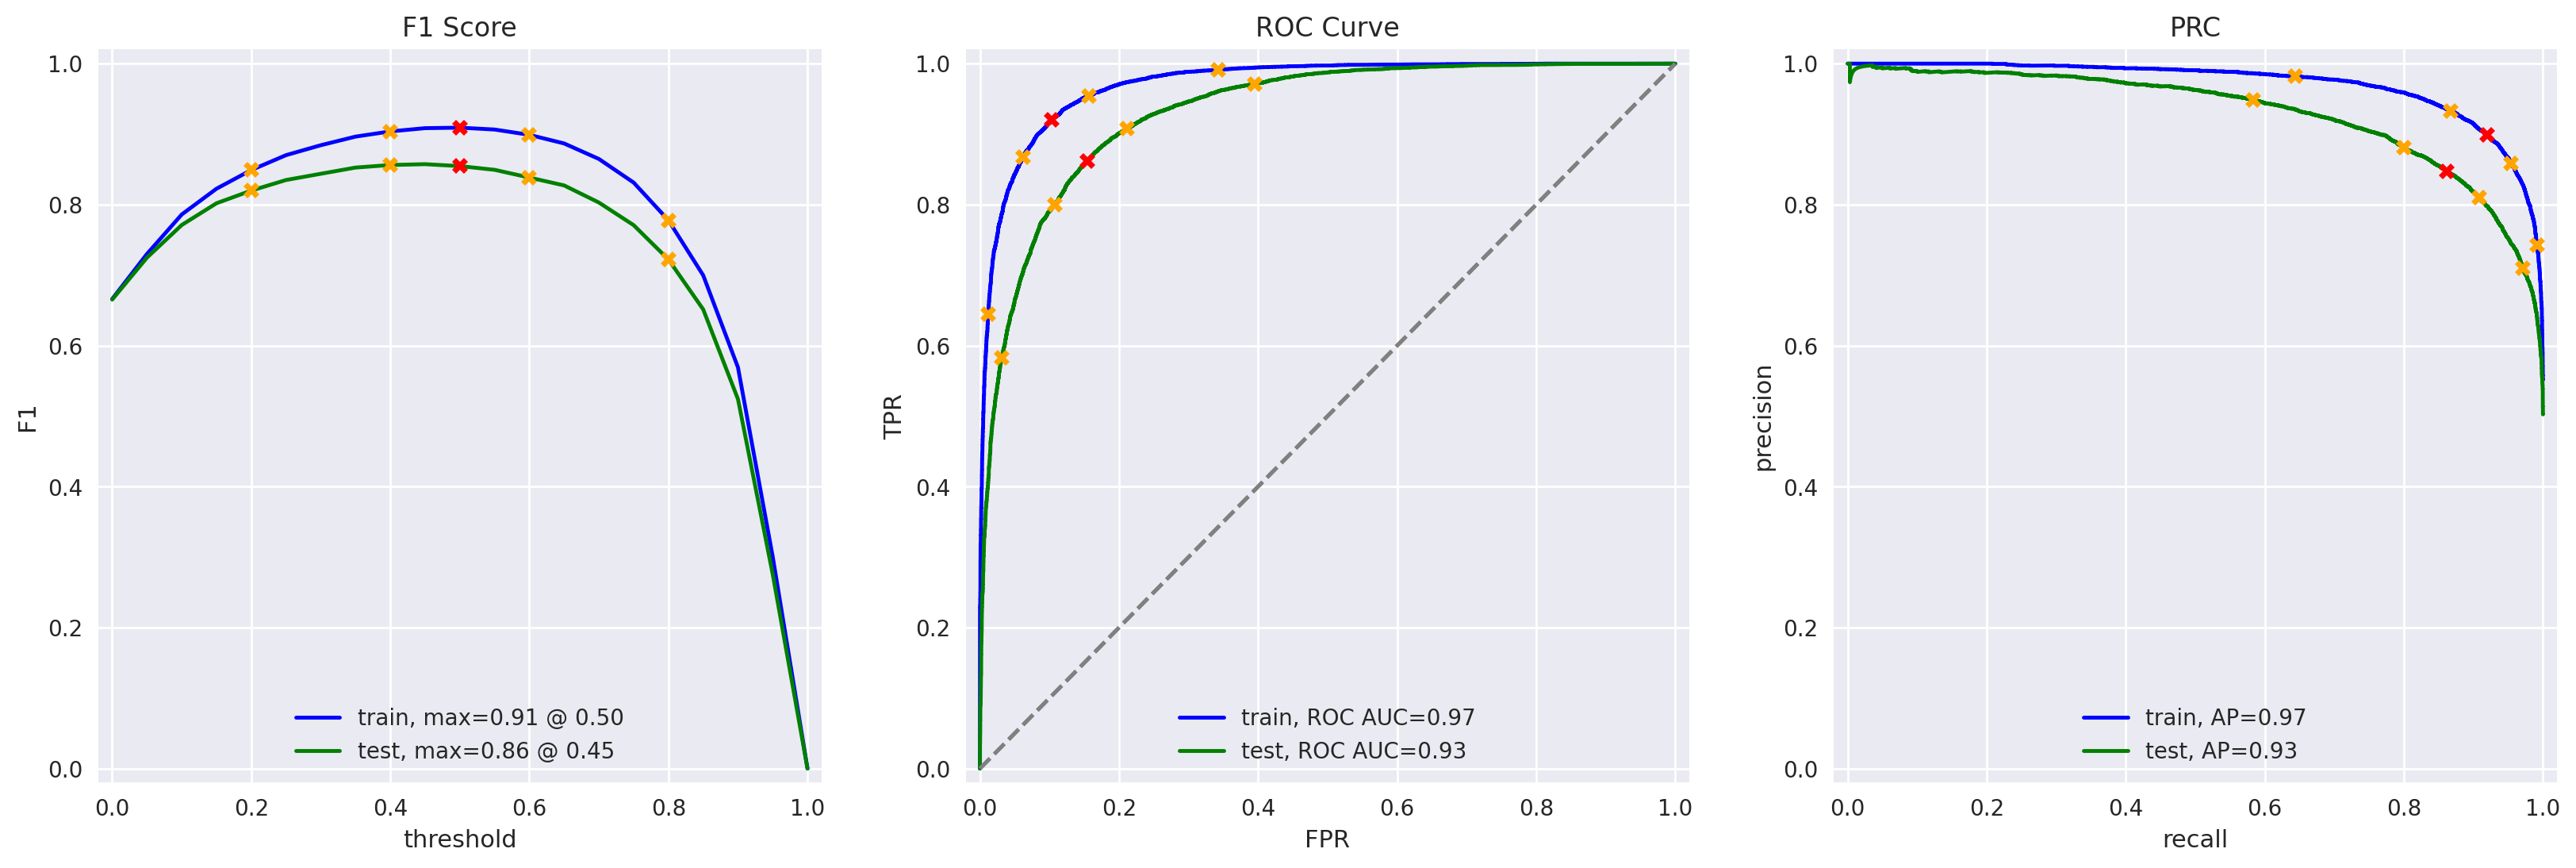

In [24]:
#create and fit model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(df_reviews_train_vec, train_target)

#evaluate model
evaluate_model(lgb_model, df_reviews_train_vec, train_target, df_reviews_test_vec, test_target)

## My Reviews

In [31]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1

In [32]:
texts = my_reviews['review_norm']

#use same fitted vectorizer from training
X_texts_vec = vectorizer.transform(texts)

#predict on trained model
my_reviews_pred_prob1 = tfidf_lr_model.predict_proba(X_texts_vec)[:, 1]

#results
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob1[i]:.2f}:  {review}')


0.09:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didnt expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob3 = tfidf_lr_model2.predict_proba(vectorizer3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob3[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didnt expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [34]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer3
my_reviews_pred_prob4 = lgb_model.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob4[i]:.2f}:  {review}')

0.62:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.51:  i didnt expect the reboot to be so good writers really cared about the source material
0.58:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.20:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

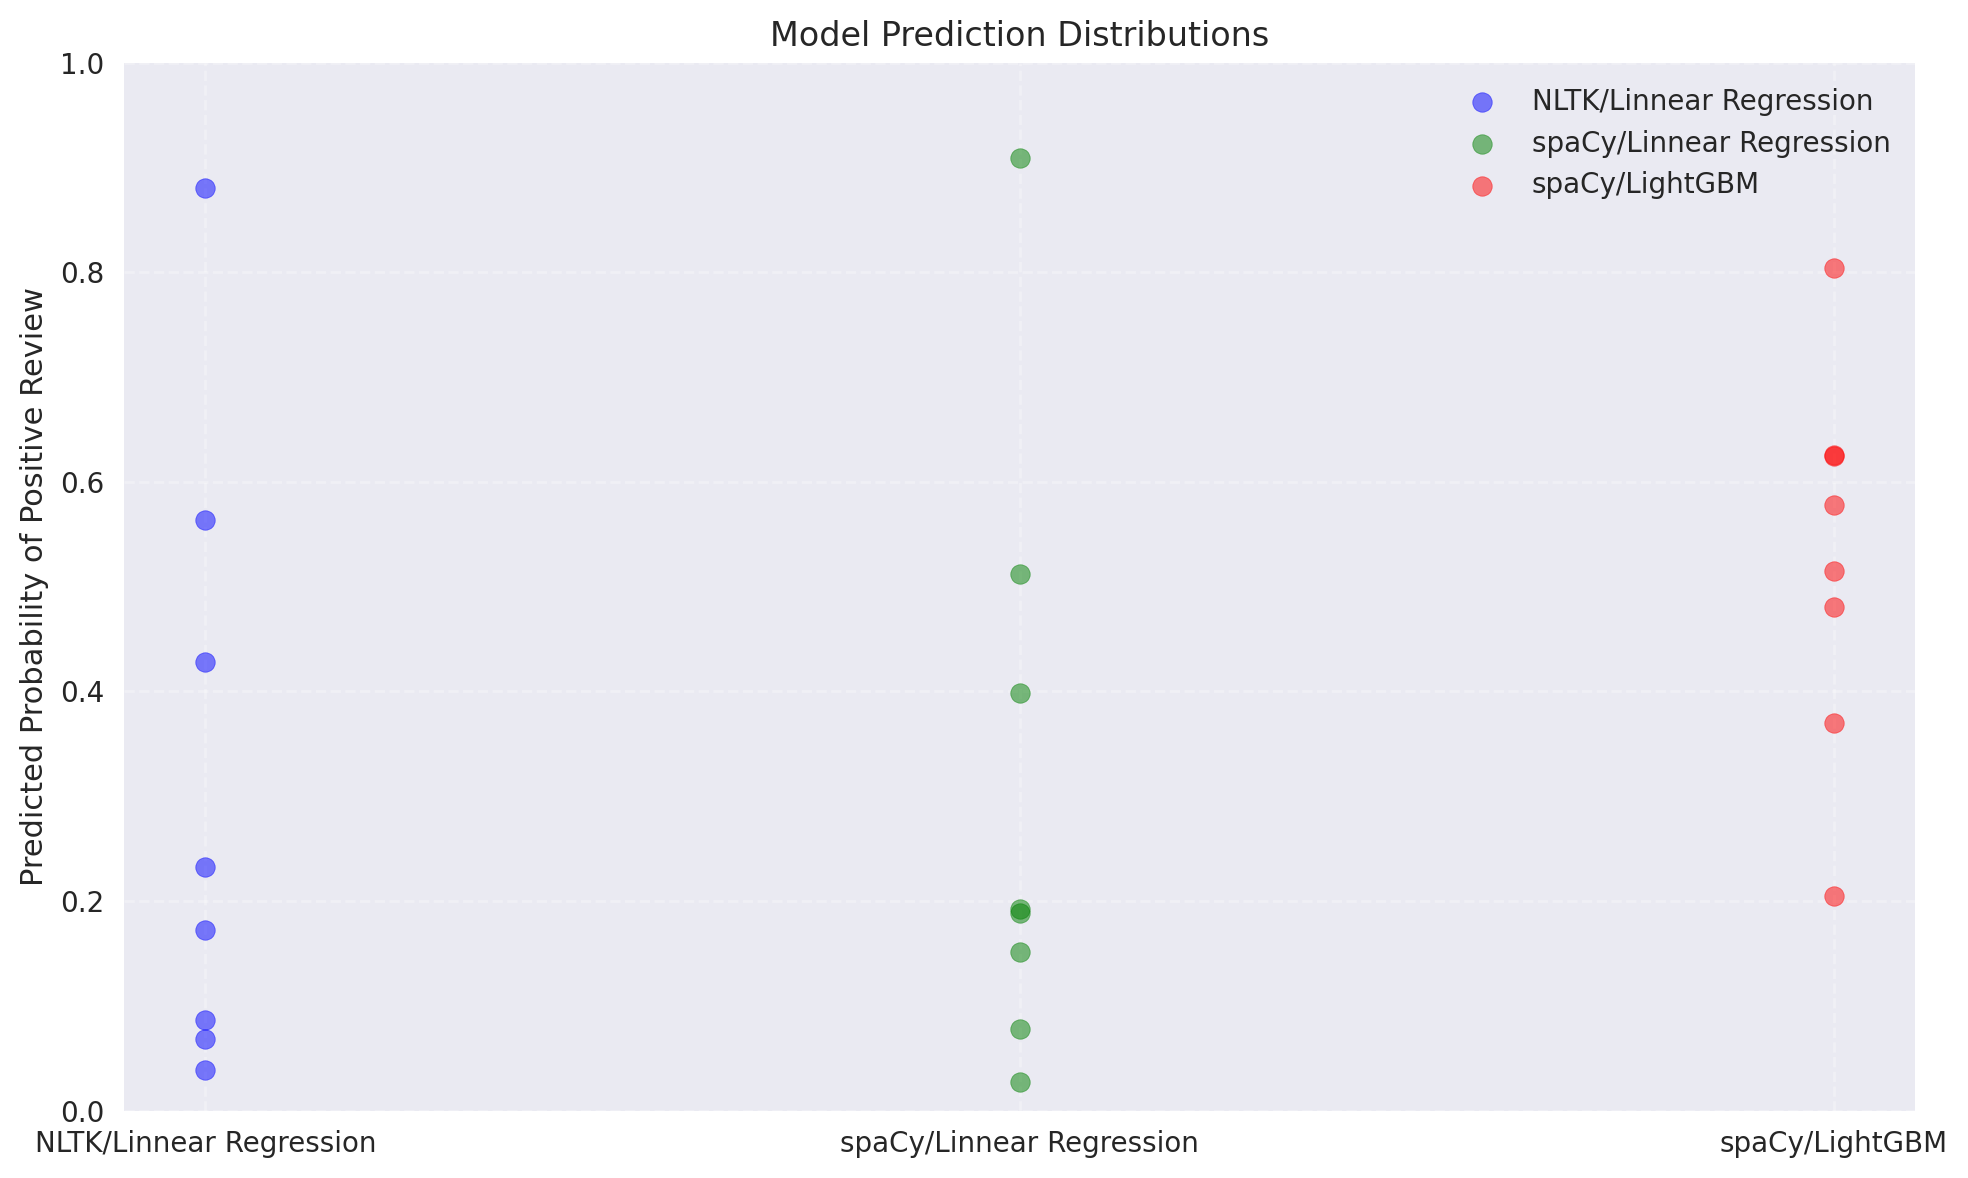

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure you have predictions ready
#lr_probs = lr_model.predict_proba(X_vec)[:, 1]
#lgb_probs = lgb_model.predict_proba(X_vec)[:, 1]
#dummy_probs = dummy_model.predict_proba(X_vec)[:, 1]

# Create positions on the x-axis for each model
x_lr = np.full_like(my_reviews_pred_prob1, fill_value=1, dtype=float)
x_lr_sp = np.full_like(my_reviews_pred_prob3, fill_value=2, dtype=float)
x_lgm_sp = np.full_like(my_reviews_pred_prob4, fill_value=3, dtype=float)

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each model's predictions
plt.scatter(x_lr, my_reviews_pred_prob1, alpha=0.5, label='NLTK/Linnear Regression', color='blue')
plt.scatter(x_lr_sp, my_reviews_pred_prob3, alpha=0.5, label='spaCy/Linnear Regression', color='green')
plt.scatter(x_lgm_sp, my_reviews_pred_prob4, alpha=0.5, label='spaCy/LightGBM', color='red')

# Set x-ticks to show model names instead of 1, 2, 3
plt.xticks([1, 2, 3], ['NLTK/Linnear Regression', 'spaCy/Linnear Regression', 'spaCy/LightGBM'])

# Y-axis: prediction probability
plt.ylim(0, 1)
plt.ylabel('Predicted Probability of Positive Review')

# Title and legend
plt.title('Model Prediction Distributions')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

When creating various models, three different models were trained and tested (excluding a dummy model).

The dummy model was used as a constant model in this scenario to see how well our models tested against it. The constant model had an F1 score of 0.5 and did not meet project standards.

The NLTK, TF_IDF, and linnear regression model (Model 1) performed well on this data with an F1 score on the test data of 0.88 and an ROC AUC score of 0.94. The F1 score meets project standards and the high ROC score indictates that the model has a high ability to distinguish between positive and negative classes.

The spaCy, TF-DIF, and linnear regression model (Model 3) performed well on this data with an F1 score on the test data of 0.87 and an ROC AUC score of 0.93. The F1 score meets project standards and the high ROC score indictates that the model has a high ability to distinguish between positive and negative classes.

The spaCy, TF-DIF, and LightGBM model (Model 4) performed well on this data with an F1 score on the test data of 0.85 and an ROC AUC score of 0.91. The F1 score meets project standards and the high ROC score indictates that the model has a high ability to distinguish between positive and negative classes.

While looking at the results from the models when used on real life data, it seems that Model 1 and Model 3 produced more similar results. Model 4 had less range and seemed less accurate overall. This model did have slightly lower ROC AUC scores than the other two, which could show that is is slightly less sensitive to distinguishing between positive and negative classes, leading to some of these classification errors. 

If the language/verbiage in these written reviews was slightly different than the language/verbiage that the models were trained on, this could lead to potential discrepencies in review classification.

# Checklist

- [x]  Notebook was opened
- [x ]  The text data is loaded and pre-processed for vectorization
- [ x]  The text data is transformed to vectors
- [ x]  Models are trained and tested
- [x ]  The metric's threshold is reached
- [x ]  All the code cells are arranged in the order of their execution
- [ x]  All the code cells can be executed without errors
- [ x]  There are conclusions